In [61]:
import os
import graphviz
from langchain_groq import ChatGroq
from langchain_core.tools import tool
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
from langchain.agents import Tool, initialize_agent
from langgraph.graph import StateGraph, END

In [13]:
os.environ["GROQ_API_KEY"] = getpass.getpass("Enter your Groq API key: ")

Enter your Groq API key:  ········


In [15]:
@tool
def destination_info(city: str) -> str:
    """Provides fun facts and highlights about a travel destination."""
    fake_database = {
        "tokyo": "Tokyo is Japan's capital, known for cherry blossoms in April, sushi, and tech innovation.",
        "paris": "Paris is famous for the Eiffel Tower, croissants, and its rich art and fashion culture.",
        "cairo": "Cairo offers ancient history, the Great Pyramids, and the Nile River."
    }
    return fake_database.get(city.lower(), f"Sorry, I have no info about {city}.")

In [17]:
@tool
def packing_list(city_and_month: str) -> str:
    """Recommends packing items based on location and season."""
    if "tokyo" in city_and_month.lower() and "april" in city_and_month.lower():
        return "Pack light layers, a jacket, comfortable shoes, and an umbrella for spring rain."
    elif "paris" in city_and_month.lower() and "july" in city_and_month.lower():
        return "Pack summer clothes, sunglasses, and a hat for sun protection."
    else:
        return "Pack accordingly based on the local climate and season."

In [19]:
# Set up tools
tools = [destination_info, packing_list]

In [21]:
llm = ChatGroq(
    model="deepseek-r1-distill-llama-70b",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

In [23]:
agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent="zero-shot-react-description",
    verbose=True,
    handle_parsing_errors=True,
)

C:\Users\ponma\AppData\Local\Temp\ipykernel_16572\974826548.py:1: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://python.langchain.com/docs/how_to/migrate_agent/>`_ and LangGraph's `Pre-built ReAct agent <https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/>`_.
  agent = initialize_agent(


In [25]:
# LangGraph Nodes
def agent_node(state):
    user_input = state["input"]
    print(f"\n🌍 Agent input:\n{user_input}")
    result = agent(user_input)
    return {
        "input": user_input,
        "result": result["output"]
    }

In [27]:
def router_node(state):
    # Returning a dictionary that signals the end of the flow
    return {"end": True}

In [51]:
from typing import TypedDict
from langgraph.graph import StateGraph, END

class GraphState(TypedDict):
    input: str
    result: str

graph = StateGraph(GraphState)
graph.add_node("agent", agent_node)
graph.add_node("router", router_node)
graph.set_entry_point("agent")
graph.add_edge("agent", "router")
graph.add_edge("router", END)

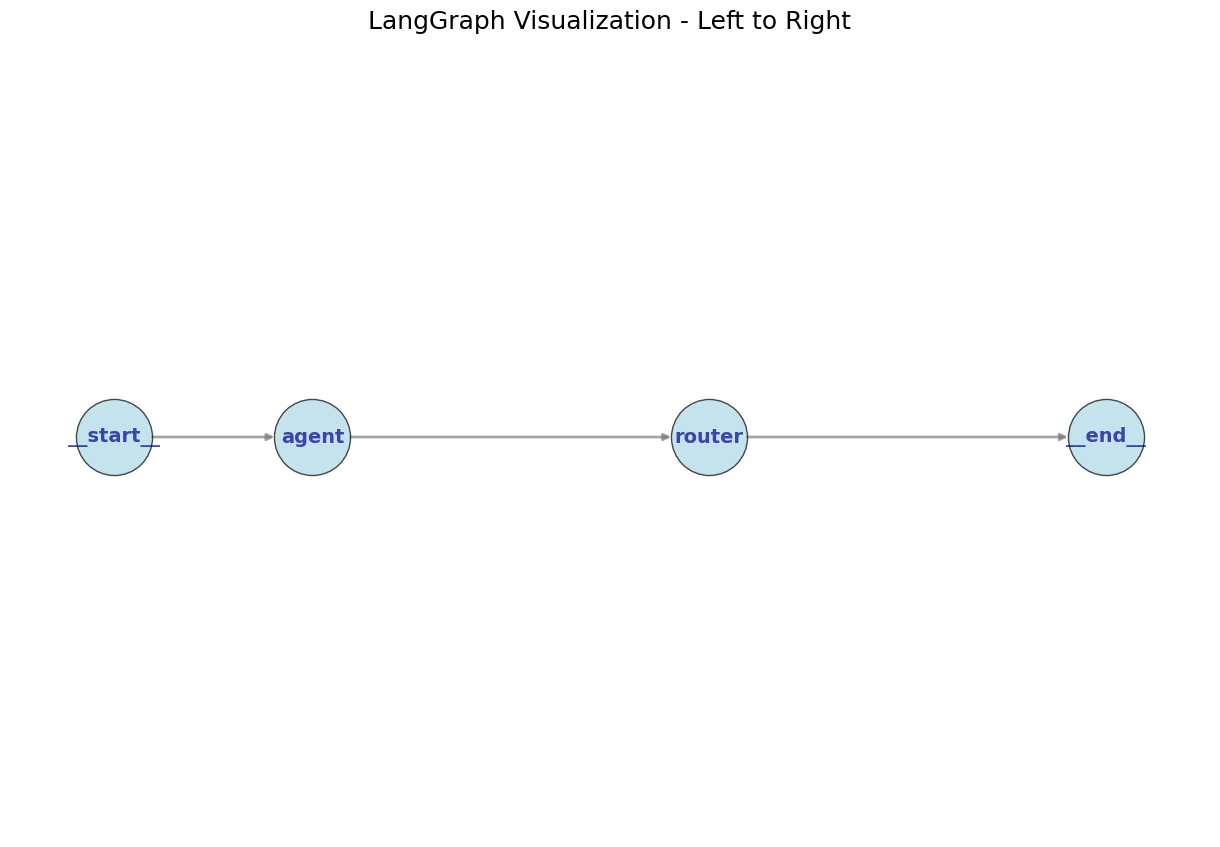

In [77]:
# Improved NetworkX and Matplotlib Visualization (Left-Middle start)

def visualize_graph(graph):
    # Create a directed graph using NetworkX
    G = nx.DiGraph()
    
    # Add nodes to the graph
    for node_name in graph.nodes:
        G.add_node(node_name)
    
    # Add edges to the graph
    for edge in graph.edges:
        G.add_edge(edge[0], edge[1])

    # Define a custom layout to start from left-middle and grow towards the right
    pos = {}
    
    # Set positions for known nodes
    pos["agent"] = (0, 0)  # Left middle
    pos["router"] = (2, 0)  # Right of "agent"
    pos["__start__"] = (-1, 0)  # To the left of "agent", this is the entry point
    pos["__end__"] = (4, 0)  # Right of "router" (far right)

    # Ensure all nodes have positions, including the start node
    all_nodes = list(graph.nodes)
    x_offset = 3  # Distance between nodes
    for i, node in enumerate(all_nodes):
        if node not in pos:  # Avoid overwriting already set positions
            pos[node] = (i * x_offset, 0)  # Spread nodes horizontally

    # Draw the graph using NetworkX and Matplotlib
    plt.figure(figsize=(12, 8))
    nx.draw(
        G, pos, 
        with_labels=True, 
        node_size=3000, 
        node_color='lightblue', 
        font_size=14, 
        font_weight='bold', 
        edge_color='gray', 
        width=2, 
        arrows=True, 
        font_color='darkblue',
        alpha=0.7,
        edgecolors='black'
    )
    
    # Set title and remove axes for better presentation
    plt.title("LangGraph Visualization - Left to Right", fontsize=18)
    plt.axis('off')  # Turn off axis
    plt.show()

# Run the visualization
visualize_graph(graph)

In [55]:
visualize_graph_manually(graph)

In [31]:
app = graph.compile()

In [33]:
query = "I'm going to Tokyo in April. Tell me about the place and what I should pack."
output = app.invoke({"input": query})

print("\n✈️ Final Output:")
print(output["result"])


🌍 Agent input:
I'm going to Tokyo in April. Tell me about the place and what I should pack.


> Entering new AgentExecutor chain...


C:\Users\ponma\AppData\Local\Temp\ipykernel_16572\1552350122.py:5: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = agent(user_input)


<think>
Okay, so the user is asking about Tokyo in April. They want to know about the place and what to pack. I need to figure out how to help them using the tools I have.

First, I should probably get some fun facts and highlights about Tokyo. That way, the user can get excited about their trip. I'll use the destination_info tool with "Tokyo" as the input.

Once I have the destination info, I'll need to help them pack. Since they're going in April, I should consider the weather and any seasonal events. I'll use the packing_list tool with "Tokyo and April" to get the right recommendations.

I should make sure the information flows well, starting with the highlights and then moving on to the packing list. That way, the user gets a comprehensive answer covering both parts of their question.
</think>

**Step-by-Step Explanation:**

1. **Understanding the Query:** The user is planning a trip to Tokyo in April and needs information about the destination and packing tips.

2. **Using Destina